## Imports and Dataset


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

# import lightgbm as lgb
from IPython.display import Markdown, display

import warnings

warnings.filterwarnings("ignore")

import utils.ml_utils as mlu


In [2]:
df = pd.read_csv("../data/clean/df-train.csv")
amount_outliers_df = pd.read_csv("../data/clean/df-amount_outliers.csv")
age_loan_outliers_df = pd.read_csv("../data/clean/df-adult_loans.csv")


## ML Models


### Apply Function


In [3]:
def apply(
    df,
    model_instance,
    parameter_grid,
    cross_validation=StratifiedKFold(n_splits=5),
    feature_selection=False,
    filter=True,
    oversample=False,
    scaler=True,
):
    return mlu.apply_cv(
        df,
        model_instance,
        parameter_grid,
        cross_validation,
        feature_selection,
        filter,
        oversample,
        scaler,
    )


##### Decision Tree


In [4]:
"""
Description:
Non-parametric supervised learning method (used for classification).
The goal is to create a model that predicts a variable (status) by learning simple decision rules inferred from the data features.
A tree can be seen as a piecewise constant approximation.

Interesting parameters to tune:
    - criterion (function used to measure the quality of a split): gini (default), entropy or log_loss
    - splitter (strategy used to choose a split): best (default) or random
    - random_state (controls the randomness of the estimator)
"""


def apply_decision_tree(df):
    parameter_grid = {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_depth": range(1, 7),
    }
    return (
        apply(
            df,
            tree.DecisionTreeClassifier,
            parameter_grid,
            oversample=oversample,
            feature_selection=feature_selection,
        )
        for oversample, feature_selection in (
            (False, False),
            (False, True),
            (True, False),
            (True, True),
        )
    )


##### Logistic Regression


In [5]:
"""
Description:
Logistic regression, despite its name, is a linear model for classification rather than regression.
Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier.
In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

Interesting parameters to tune:
    - max_iter (maximum number of iterations taken for the solvers to converge, default 100)
    - solver (algorithm to use in the optimization problem): lbfgs (default)

Some notes on the solver:
    - for small datasets, liblinear is a good choice, whereas sag and saga are faster for large ones;
    - for multiclass problems, only newton-cg, sag, saga and lbfgs handle multinomial loss;
    - liblinear is limited to one-versus-rest schemes.
"""


def apply_logistic_regression(df):
    parameter_grid = {
        "penalty": ["l2", "none"],
        "C": [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
        "solver": ["newton-cg", "lbfgs", "sag", "saga"],
        "class_weight": ["balanced", None],
        "max_iter": [500, 1000, 5000, 10000],
    }
    return (
        apply(
            df,
            LogisticRegression,
            parameter_grid,
            oversample=oversample,
            feature_selection=feature_selection,
        )
        for oversample, feature_selection in (
            (False, False),
            (False, True),
            (True, False),
            (True, True),
        )
    )


##### Naive Bayes


In [6]:
"""
Description:
Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ 
theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable.

Draw the Gaussian Distribution to each of the independent variables and apply the likelihood of each given value to the prior probability.
"""


def apply_naive_bayes(df):
    return (
        apply(
            df,
            GaussianNB,
            {},
            oversample=oversample,
            feature_selection=feature_selection,
        )
        for oversample, feature_selection in (
            (False, False),
            (False, True),
            (True, False),
            (True, True),
        )
    )


##### K-Nearest Neighbors


In [7]:
"""
Description:
Neighbors-based classification is a type of instance-based learning or non-generalizing learning:
it does not attempt to construct a general internal model, but simply stores instances of the training data.

Classification is computed from a simple majority vote of the nearest neighbors of each point:
a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.
"""


def apply_k_nearest_neighbours(df):
    parameter_grid = {
        "n_neighbors": [4, 5, 6, 7, 10, 15],
        "leaf_size": [5, 10, 15, 20, 50, 100],
        "n_jobs": [-1],
        "algorithm": ["auto"],
    }
    return (
        apply(
            df,
            KNeighborsClassifier,
            parameter_grid,
            oversample=oversample,
            feature_selection=feature_selection,
        )
        for oversample, feature_selection in (
            (False, False),
            (False, True),
            (True, False),
            (True, True),
        )
    )


##### Random Forest


In [8]:
"""
Description:
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset
 and uses averaging (votes) to improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

Interesting parameters to tune:
    - n_estimators (number of trees in the forest, default 100)
    - criterion (function used to measure the quality of a split): gini (default), entropy or log_loss
    - max_depth (maximum depth of the tree, default None)
    - n_jobs
"""


def apply_random_forest(df):

    parameter_grid = {
        "n_estimators": [10, 50, 100, 200],
        "max_depth": [5, 10, None],
        "n_jobs": [-1],  # Use all cores
        "criterion": ["gini", "entropy"],
    }
    return (
        apply(
            df,
            RandomForestClassifier,
            parameter_grid,
            oversample=oversample,
            feature_selection=feature_selection,
            scaler=False,
        )
        for oversample, feature_selection in (
            (False, False),
            (False, True),
            (True, False),
            (True, True),
        )
    )


##### Gradient Boosting


In [9]:
"""
Description:
Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions.
GBDT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems
 in a variety of areas including Web search ranking and ecology.
Similar to Random forest with the improvement from tree to tree (loss decrease)
"""


def apply_gradient_boosting(df):
    parameter_grid = {
        "n_estimators": [int(x) for x in range(2, 14, 2)],
        "learning_rate": [0.1, 0.3, 0.5, 0.7],
        "loss": ["deviance", "exponential", "log_loss"],
        "criterion": ["friedman_mse", "squared_error", "mse"],
        "min_samples_split": [4, 6, 8],
        "min_samples_leaf": [2, 4, 6],
    }
    return (
        apply(
            df,
            GradientBoostingClassifier,
            parameter_grid,
            oversample=oversample,
            feature_selection=feature_selection,
        )
        for oversample, feature_selection in (
            (False, False),
            (False, True),
            (True, False),
            (True, True),
        )
    )


##### SVC


In [10]:
"""
Description:
SVC separates the set of points (items) with a line or plane into different areas of the space.
These areas allow us to predict if a given point is of a specific class or not.
"""


def apply_svc(df):
    parameter_grid = {
        "C": [1, 10, 50],
        "gamma": [0.001, 0.0001, 0.01, 1, "scale", "auto"],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": [1, 2, 3, 4, 5, 6, 7],
        "coef0": [0.0, 0.1, 0.3, 0.5, 0.7],
        "max_iter": [1, 2, 3, 5, 7, 10],
        "decision_function_shape": ["ovo", "ovr"],
        "class_weight": [None, "balanced", dict],
    }
    return (
        apply(
            df,
            SVC,
            parameter_grid,
            oversample=oversample,
            feature_selection=feature_selection,
        )
        for oversample, feature_selection in (
            (False, False),
            (False, True),
            (True, False),
            (True, True),
        )
    )


##### MLP


In [11]:
"""
Description:
"""


def apply_mlp(df):
    parameter_grid = {
        "hidden_layer_sizes": [(3, 5, 8, 13, 21, 34)],
        "activation": ["identity", "logistic", "tanh", "relu"],
        "solver": ["lbfgs", "sgd", "adam"],
        "learning_rate": ["constant", "invscaling", "adaptive"],
        "nesterovs_momentum": [True, False],
        "early_stopping": [False, True],
    }
    return (
        apply(
            df,
            MLPClassifier,
            parameter_grid,
            oversample=oversample,
            feature_selection=feature_selection,
        )
        for oversample, feature_selection in (
            (False, False),
            (False, True),
            (True, False),
            (True, True),
        )
    )


##### XGBOOST


In [12]:
def apply_xgboost(df):
    parameter_grid = {
        "min_child_weight": range(1, 6, 2),
        "gamma": [0, 0.2, 0.5, 1, 1.5, 3],
        "max_depth": [5, 8, 10, 15],
        "reg_alpha": [1e-5, 1e-2, 0.1, 1],
    }
    return (
        apply(
            df,
            XGBClassifier,
            parameter_grid,
            oversample=oversample,
            feature_selection=feature_selection,
        )
        for oversample, feature_selection in (
            (False, False),
            (False, True),
            (True, False),
            (True, True),
        )
    )


### Testing & Comparing Models


In [13]:
import seaborn as sb


def compare_models(data):
    scores = {
        "Decision Tree": data["dt"],
        "Logistic Regression": data["lr"],
        "Naive Bayes": data["nb"],
        "K-nearest Neighbours": data["knn"],
        "Random Forest": data["rf"],
        "xgboost": data["xg"],
        "Gradient Boosting": data["gb"],
        "SVC": data["svc"],
    }

    x_axis_labels = [
        "No Feature selection/No oversampling",
        "Feature Selection",
        "Oversampling",
        "Feature Selection/Oversampling",
    ]
    y_axis_labels = scores.keys()

    plt.figure(figsize=(10, 8))

    scores_array = np.array([[score for score in model] for model in scores.values()])

    sb.set(font_scale=1.3)
    sb.heatmap(
        scores_array,
        annot=True,
        linewidths=0.5,
        vmax=1,
        square=True,
        xticklabels=x_axis_labels,
        yticklabels=y_axis_labels,
        cbar=False,
    )
    plt.title("ROC-AUC")

    plt.xticks(rotation=45, horizontalalignment="right")
    plt.show()


In [14]:
display(Markdown(f"## Random Forest "))
rf, rf_fs, rf_os, rf_fs_os = apply_random_forest(df)
display(Markdown("---"))

## Random Forest 

### Neither oversample nor feature selection

Best parameters:
 {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1}

**fit_time**: 0.06559886932373046

**score_time**: 0.02151932716369629

**test_accuracy**: 0.903961352657005

**test_roc_auc**: 0.8374328449328449

**test_precision**: 1.0

### Feature selection

Best parameters:
 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50, 'n_jobs': -1}

**fit_time**: 0.019673633575439452

**score_time**: 0.009128522872924805

**test_accuracy**: 0.8952657004830918

**test_roc_auc**: 0.7671626984126982

**test_precision**: 0.7666666666666667

### Oversample

Best parameters:
 {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 10, 'n_jobs': -1}

**fit_time**: 0.1361849784851074

**score_time**: 0.004894399642944336

**test_accuracy**: 0.8384541062801931

**test_roc_auc**: 0.8006959706959706

**test_precision**: 0.38051948051948054

### Feature selection and oversample

Best parameters:
 {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 10, 'n_jobs': -1}

**fit_time**: 0.008153295516967774

**score_time**: 0.005454730987548828

**test_accuracy**: 0.8778743961352656

**test_roc_auc**: 0.8373809523809523

**test_precision**: 0.5894444444444444

---

In [15]:
display(Markdown(f"## XGBoost "))
xg, xg_fs, xg_os, xg_fs_os = apply_xgboost(df)
display(Markdown("---"))

## XGBoost 

### Neither oversample nor feature selection

Best parameters:
 {'gamma': 0, 'max_depth': 5, 'min_child_weight': 1, 'reg_alpha': 0.01}

**fit_time**: 0.1828909397125244

**score_time**: 0.003260040283203125

**test_accuracy**: 0.8822222222222222

**test_roc_auc**: 0.7057326007326007

**test_precision**: 0.65

### Feature selection

Best parameters:
 {'gamma': 3, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1}

**fit_time**: 0.1906507968902588

**score_time**: 0.0032446861267089845

**test_accuracy**: 0.8472463768115943

**test_roc_auc**: 0.8162789987789989

**test_precision**: 0.0

### Oversample

Best parameters:
 {'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'reg_alpha': 1}

**fit_time**: 0.41280522346496584

**score_time**: 0.0034036159515380858

**test_accuracy**: 0.8208695652173914

**test_roc_auc**: 0.8033241758241759

**test_precision**: 0.29757575757575755

### Feature selection and oversample

Best parameters:
 {'gamma': 1, 'max_depth': 10, 'min_child_weight': 1, 'reg_alpha': 0.01}

**fit_time**: 0.3559060573577881

**score_time**: 0.003528594970703125

**test_accuracy**: 0.8210628019323671

**test_roc_auc**: 0.7863583638583639

**test_precision**: 0.3651082251082251

---

In [16]:
display(Markdown(f"## Decision Tree "))
dt, dt_fs, dt_os, dt_fs_os = apply_decision_tree(df)
display(Markdown("---"))

## Decision Tree 

### Neither oversample nor feature selection

Best parameters:
 {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}

**fit_time**: 0.0007642269134521485

**score_time**: 0.0014041900634765626

**test_accuracy**: 0.877487922705314

**test_roc_auc**: 0.8091239316239317

**test_precision**: 0.72

### Feature selection

Best parameters:
 {'criterion': 'log_loss', 'max_depth': 3, 'splitter': 'random'}

**fit_time**: 0.0012148380279541015

**score_time**: 0.0014349460601806641

**test_accuracy**: 0.8997101449275362

**test_roc_auc**: 0.8256776556776556

**test_precision**: 0.8

### Oversample

Best parameters:
 {'criterion': 'gini', 'max_depth': 4, 'splitter': 'random'}

**fit_time**: 0.0037462711334228516

**score_time**: 0.0014744281768798828

**test_accuracy**: 0.7504347826086957

**test_roc_auc**: 0.7447115384615384

**test_precision**: 0.3338383838383838

### Feature selection and oversample

Best parameters:
 {'criterion': 'gini', 'max_depth': 6, 'splitter': 'best'}

**fit_time**: 0.0022320270538330076

**score_time**: 0.0015247344970703125

**test_accuracy**: 0.7511111111111111

**test_roc_auc**: 0.6936187423687424

**test_precision**: 0.2872689075630252

---

In [17]:
display(Markdown(f"## Gradient Boosting "))
gb, gb_fs, gb_os, gb_fs_os = apply_gradient_boosting(df)
display(Markdown("---"))

## Gradient Boosting 

### Neither oversample nor feature selection

Best parameters:
 {'criterion': 'squared_error', 'learning_rate': 0.7, 'loss': 'deviance', 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 6}

**fit_time**: 0.004672861099243164

**score_time**: 0.0016011714935302735

**test_accuracy**: 0.8867632850241545

**test_roc_auc**: 0.7574053724053724

**test_precision**: 0.5809523809523809

### Feature selection

Best parameters:
 {'criterion': 'friedman_mse', 'learning_rate': 0.3, 'loss': 'log_loss', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2}

**fit_time**: 0.0018524169921875

**score_time**: 0.0015134334564208985

**test_accuracy**: 0.8560386473429951

**test_roc_auc**: 0.6912698412698413

**test_precision**: 0.6

### Oversample

Best parameters:
 {'criterion': 'friedman_mse', 'learning_rate': 0.7, 'loss': 'deviance', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 12}

**fit_time**: 0.018010520935058595

**score_time**: 0.0015930652618408204

**test_accuracy**: 0.8075362318840579

**test_roc_auc**: 0.7102869352869352

**test_precision**: 0.3738095238095238

### Feature selection and oversample

Best parameters:
 {'criterion': 'mse', 'learning_rate': 0.7, 'loss': 'deviance', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 6}

**fit_time**: 0.004618787765502929

**score_time**: 0.0016006946563720704

**test_accuracy**: 0.8298550724637682

**test_roc_auc**: 0.7354273504273504

**test_precision**: 0.4

---

In [18]:
display(Markdown(f"## K Nearest Neighbours "))
knn, knn_fs, knn_os, knn_fs_os = apply_k_nearest_neighbours(df)
display(Markdown("---"))

## K Nearest Neighbours 

### Neither oversample nor feature selection

Best parameters:
 {'algorithm': 'auto', 'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 15}

**fit_time**: 0.0006254673004150391

**score_time**: 0.004001188278198242

**test_accuracy**: 0.8646376811594202

**test_roc_auc**: 0.7033470695970696

**test_precision**: 0.2

### Feature selection

Best parameters:
 {'algorithm': 'auto', 'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 4}

**fit_time**: 0.0013393878936767579

**score_time**: 0.007513809204101563

**test_accuracy**: 0.8952657004830918

**test_roc_auc**: 0.7668818681318681

**test_precision**: 0.9199999999999999

### Oversample

Best parameters:
 {'algorithm': 'auto', 'leaf_size': 10, 'n_jobs': -1, 'n_neighbors': 5}

**fit_time**: 0.003879833221435547

**score_time**: 0.00830683708190918

**test_accuracy**: 0.6765217391304348

**test_roc_auc**: 0.6970558608058608

**test_precision**: 0.24662553820448557

### Feature selection and oversample

Best parameters:
 {'algorithm': 'auto', 'leaf_size': 15, 'n_jobs': -1, 'n_neighbors': 10}

**fit_time**: 0.0017722129821777343

**score_time**: 0.007961797714233398

**test_accuracy**: 0.7427053140096618

**test_roc_auc**: 0.778756105006105

**test_precision**: 0.30983349983349984

---

In [19]:
display(Markdown(f"## Logistic Regression "))
lr, lr_fs, lr_os, lr_fs_os = apply_logistic_regression(df)
display(Markdown("---"))

## Logistic Regression 

### Neither oversample nor feature selection

Best parameters:
 {'C': 0.5, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'}

**fit_time**: 0.002526712417602539

**score_time**: 0.0013741493225097657

**test_accuracy**: 0.812463768115942

**test_roc_auc**: 0.8324633699633699

**test_precision**: 0.39192307692307693

### Feature selection

Best parameters:
 {'C': 0.05, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'none', 'solver': 'sag'}

**fit_time**: 0.006953668594360351

**score_time**: 0.0014296531677246093

**test_accuracy**: 0.8255072463768116

**test_roc_auc**: 0.8819810744810745

**test_precision**: 0.4446464646464646

### Oversample

Best parameters:
 {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}

**fit_time**: 0.010702085494995118

**score_time**: 0.001513051986694336

**test_accuracy**: 0.7777777777777778

**test_roc_auc**: 0.7929304029304027

**test_precision**: 0.33365079365079364

### Feature selection and oversample

Best parameters:
 {'C': 0.2, 'class_weight': None, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'sag'}

**fit_time**: 0.002146196365356445

**score_time**: 0.0015128135681152343

**test_accuracy**: 0.7689855072463769

**test_roc_auc**: 0.8361630036630038

**test_precision**: 0.36086956521739133

---

In [20]:
display(Markdown(f"## Naive Bayes "))
nb, nb_fs, nb_os, nb_fs_os = apply_naive_bayes(df)
display(Markdown("---"))

## Naive Bayes 

### Neither oversample nor feature selection

Best parameters:
 {}

**fit_time**: 0.0008540630340576171

**score_time**: 0.0017591476440429687

**test_accuracy**: 0.44917874396135266

**test_roc_auc**: 0.7708333333333333

**test_precision**: 0.207825116387735

### Feature selection

Best parameters:
 {}

**fit_time**: 0.0013033390045166016

**score_time**: 0.0015269279479980468

**test_accuracy**: 0.8646376811594202

**test_roc_auc**: 0.8485164835164836

**test_precision**: 0.52

### Oversample

Best parameters:
 {}

**fit_time**: 0.004393434524536133

**score_time**: 0.0015314102172851562

**test_accuracy**: 0.5104347826086956

**test_roc_auc**: 0.8044078144078144

**test_precision**: 0.22006734006734008

### Feature selection and oversample

Best parameters:
 {}

**fit_time**: 0.0016741752624511719

**score_time**: 0.0015856266021728516

**test_accuracy**: 0.738743961352657

**test_roc_auc**: 0.8143192918192919

**test_precision**: 0.3923076923076923

---

In [21]:
display(Markdown(f"## SVC "))
svc, svc_fs, svc_os, svc_fs_os = apply_svc(df)
display(Markdown("---"))

## SVC 

### Neither oversample nor feature selection

Best parameters:
 {'C': 10, 'class_weight': None, 'coef0': 0.3, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': 10}

**fit_time**: 0.0007693290710449219

**score_time**: 0.001468324661254883

**test_accuracy**: 0.5111111111111111

**test_roc_auc**: 0.6364713064713066

**test_precision**: 0.17536917562724014

### Feature selection

Best parameters:
 {'C': 1, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 7, 'gamma': 0.0001, 'kernel': 'poly', 'max_iter': 10}

**fit_time**: 0.0012546539306640624

**score_time**: 0.0015022754669189453

**test_accuracy**: 0.5547826086956522

**test_roc_auc**: 0.7717826617826617

**test_precision**: 0.22166666666666668

### Oversample

Best parameters:
 {'C': 1, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 0.0001, 'kernel': 'rbf', 'max_iter': 10}

**fit_time**: 0.004208803176879883

**score_time**: 0.001644468307495117

**test_accuracy**: 0.6720772946859903

**test_roc_auc**: 0.647057387057387

**test_precision**: 0.23669093055282317

### Feature selection and oversample

Best parameters:
 {'C': 50, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 7, 'gamma': 0.0001, 'kernel': 'linear', 'max_iter': 7}

**fit_time**: 0.001688385009765625

**score_time**: 0.0015204429626464843

**test_accuracy**: 0.6020289855072465

**test_roc_auc**: 0.6515415140415141

**test_precision**: 0.1598168498168498

---

In [22]:
display(Markdown(f"## MLP "))
mlp, mlp_fs, mlp_os, mlp_fs_os = apply_mlp(df)
display(Markdown("---"))

## MLP 

### Neither oversample nor feature selection

Best parameters:
 {'activation': 'identity', 'early_stopping': False, 'hidden_layer_sizes': (3, 5, 8, 13, 21, 34), 'learning_rate': 'constant', 'nesterovs_momentum': True, 'solver': 'adam'}

**fit_time**: 0.05553092956542969

**score_time**: 0.0014368534088134766

**test_accuracy**: 0.8734299516908213

**test_roc_auc**: 0.86491452991453

**test_precision**: 0.5471428571428572

### Feature selection

Best parameters:
 {'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (3, 5, 8, 13, 21, 34), 'learning_rate': 'constant', 'nesterovs_momentum': True, 'solver': 'sgd'}

**fit_time**: 0.006872367858886719

**score_time**: 0.0015324592590332032

**test_accuracy**: 0.42666666666666664

**test_roc_auc**: 0.5986233211233211

**test_precision**: 0.08318840579710145

### Oversample

Best parameters:
 {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (3, 5, 8, 13, 21, 34), 'learning_rate': 'adaptive', 'nesterovs_momentum': False, 'solver': 'lbfgs'}

**fit_time**: 0.18345861434936522

**score_time**: 0.002523326873779297

**test_accuracy**: 0.7908212560386473

**test_roc_auc**: 0.7085790598290597

**test_precision**: 0.3376190476190476

### Feature selection and oversample

Best parameters:
 {'activation': 'identity', 'early_stopping': True, 'hidden_layer_sizes': (3, 5, 8, 13, 21, 34), 'learning_rate': 'adaptive', 'nesterovs_momentum': False, 'solver': 'lbfgs'}

**fit_time**: 0.06703824996948242

**score_time**: 0.002553081512451172

**test_accuracy**: 0.7510144927536231

**test_roc_auc**: 0.7840384615384616

**test_precision**: 0.30047619047619045

---

In [23]:
models_comparison = {}
models_comparison["main"] = {
    "dt": [dt, dt_fs, dt_os, dt_fs_os],
    "gb": [gb, gb_fs, gb_os, gb_fs_os],
    "knn": [knn, knn_fs, knn_os, knn_fs_os],
    "lr": [lr, lr_fs, lr_os, lr_fs_os],
    "nb": [nb, nb_fs, nb_os, nb_fs_os],
    "xg": [xg, xg_fs, xg_os, xg_fs_os],
    'svc':[svc, svc_fs, svc_os, svc_fs_os],
    "mlp": [mlp, mlp_fs, mlp_os, mlp_fs_os],
    "rf": [rf, rf_fs, rf_os, rf_fs_os],
}


# **Compare models** 

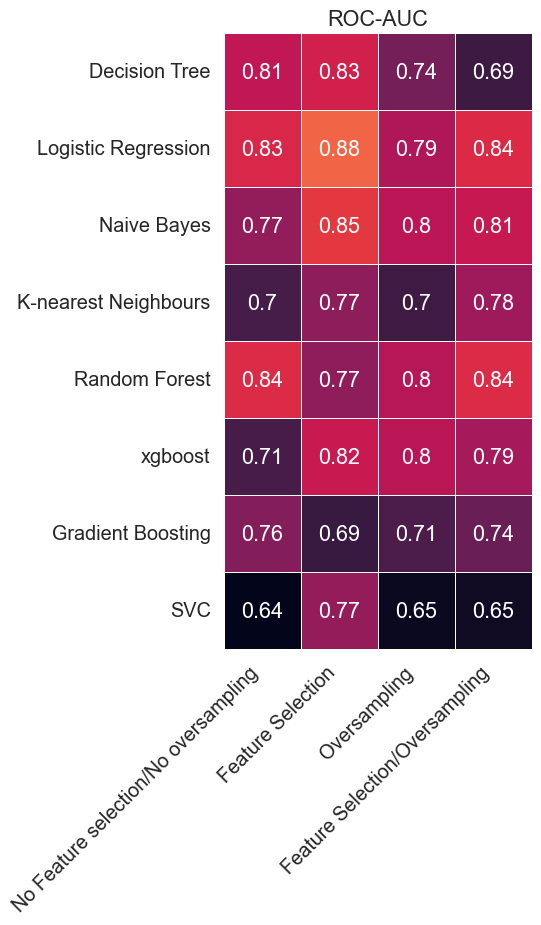

In [24]:
display(Markdown(f"# **Compare models** "))
compare_models(models_comparison["main"])

### Compare models with all dataframes
# for key in dfs.keys():
#   display(Markdown(f"## {key} "))

#   compare_models(models_comparison[key])
